In [1]:
# d6598 
# "I bet computers can't make music"
# - Felonious Gru

# Note: Use "source activate tensorflow2_p36" on Ec2

beat_resolution = 4 # Standard of 24 for full 34 and 44 representation.
                    # Dont go below 8 otherwise risk distortion. 12 is a safe spot to end up
lookback = beat_resolution * 4 * 4  # Approx 2 bars
step = 1  # Skip through it a bit
num_pitches = 52  # Must be even cause odd numbers suck


import tensorflow as tf
import functions
import train
import generate
import datetime

import IPython  # For the magic lines
%matplotlib inline
%load_ext tensorboard

Lower bound 38.
Upper bound 90.
Num pitches 52
---
midi/bwv537.mid input shape: (2477, 128)
...Refined down 76 dimensions with 72 note loss.
...Loss of 0.73 %
...Output shape: (2477, 52)
---
midi/bwv539.mid input shape: (2224, 128)
...Refined down 76 dimensions with 8 note loss.
...Loss of 0.11 %
...Output shape: (2224, 52)
---
midi/bwv653.mid input shape: (916, 128)
...Refined down 76 dimensions with 30 note loss.
...Loss of 0.82 %
...Output shape: (916, 52)
Extended output shape (5617, 52)


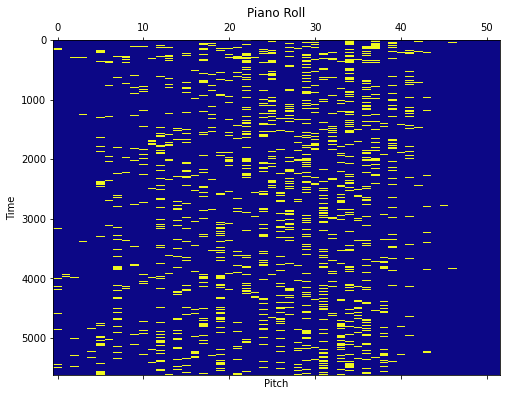

5553 individual phrases.
Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 64, 52)]          0         
_________________________________________________________________
conv1d (Conv1D)              (None, 64, 32)            13344     
_________________________________________________________________
lstm (LSTM)                  (None, 64, 128)           82432     
_________________________________________________________________
lstm_1 (LSTM)                (None, 256)               394240    
_________________________________________________________________
dense (Dense)                (None, 128)               32896     
_________________________________________________________________
dense_1 (Dense)              (None, 52)                6708      
Total params: 529,620
Trainable params: 529,620
Non-trainable params: 0
______________________________

In [2]:
log_dir = "logs/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")

music = functions.Midi(num_pitches, beat_resolution=beat_resolution)
music.load_midi(['midi/bwv537.mid', 'midi/bwv539.mid', 'midi/bwv653.mid'])
music.display()

x, y = music.vectorise(lookback, step=1)
tempo = music.tempo

gru = train.Gru("lstm-v15")
gru.build(lookback, num_pitches, loss="binary_crossentropy")

callbacks = [
    tf.keras.callbacks.EarlyStopping(patience=3, restore_best_weights=False, monitor="loss"),  # Stop early if training is only going ok
    train.GenerateMusic(music.roll, gen_every=3, temp=0.7),  # Generate some music
    tf.keras.callbacks.ModelCheckpoint(gru.model_dir + gru.name + ".h5",
                                       save_best_only=True, monitor="loss"),
    tf.keras.callbacks.ProgbarLogger(),
    tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1)
]

In [3]:
gru.model.layers[0].input_shape

[(None, 64, 52)]

In [4]:
historys = gru.train(x, y, 10, callbacks, batch_size=256)
#train.plot_history(historys)
#gru.load("models/lstm-v15.h5")

Epoch 1/10
      0/Unknown - 24s 0s/sample - loss: 0.2865 - accuracy: 0.0137 - mean_absolute_error: 0.1741

KeyError: 'accuracy'

In [ ]:
# Can also run without % in the command line
%tensorboard --logdir logs/

In [5]:
temps = [0.2, 0.35, 0.4, 0.45, 0.5, 0.6, 0.8, 1.0]

outputs = {}
for temp in temps:
    outputs["Temp-" + str(temp)] = generate.generate_music(gru.model, music.roll, temp, length=lookback*4, noise=True)
generate.multi_save(outputs, 'outputs/generated-v15.mid')

Generating with seed index of 2502
Generating roll with temp 0.2 and length 256
Generating with seed index of 648
Generating roll with temp 0.35 and length 256
Generating with seed index of 2406
Generating roll with temp 0.4 and length 256
Generating with seed index of 5177
Generating roll with temp 0.45 and length 256
Generating with seed index of 2633
Generating roll with temp 0.5 and length 256
Generating with seed index of 5383
Generating roll with temp 0.6 and length 256
Generating with seed index of 3881
Generating roll with temp 0.8 and length 256
Generating with seed index of 1428
Generating roll with temp 1.0 and length 256
Roll is cut down to only 52 notes
Roll is cut down to only 52 notes
Roll is cut down to only 52 notes
Roll is cut down to only 52 notes
Roll is cut down to only 52 notes
Roll is cut down to only 52 notes
Roll is cut down to only 52 notes
Roll is cut down to only 52 notes
Saving 8 tracks in one file "outputs/generated-v15.mid".
Saved file "outputs/generated-